<a href="https://colab.research.google.com/github/Hamid-Mofidi/PNP/blob/main/Bifurcation_of_lambda/bif_of_lam_new2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This code is for the bifurcation analysis of flux ratio for studying the
effects of permanent charges on ionic flows

In [1]:
from scipy.optimize import root
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def equations(x):
    A, I, V, l = x

    k = 1
    r = 2
    eps = 1e-15 #  a small number

    sqA    = np.sqrt(1+A**2)
    sqB    = np.sqrt(1+(l-A+r)**2) #assume that alpha=1/3, beta=2/3
    logAB  = np.log(np.maximum( (l-A+r)*(sqA-1), eps)/np.maximum( A*(sqB-1), eps) )
    rho    = (A-l)**2 + (sqA - sqB)*(A-l)
    sigma  = l/r
    logSBA = np.log(np.maximum( sigma*(l-A+r) , eps)/ np.maximum(A, eps) ) # not a real number
    siglog = 3*sigma*np.log( np.maximum( sigma, eps) )/(l*(sigma-1))

    numI1   = (( (-1)**(k+1) )*siglog) * (A-l)**2
    numI2   = (logAB - ((-1)**k) * np.log( np.maximum(sigma, eps) ))*(A-l+eps)
    gamma1  = 1/(I-(A-l) * sqA)
    gamma2  = 1/(I-(A-l) * sqB)
    M       = I * (gamma2 - gamma1)+ rho/I
    ABGamma = A * gamma1 + (l-A+r) * gamma2
    ABGammaR= (1/A) * gamma1 + (1/(l-A+r)) * gamma2
    G41     = ( 1- (A-l)*ABGamma )*( logSBA + (A-l) * siglog )
    G42     = ( 1- (A-l)*ABGamma )* M
    G43     = ( I+ ( ((-1)**k) * (A-l) ) ) * siglog * M/(A-l)
    GR      =( ( I**2-(A-l)**2 )/(A-l) ) * M * ABGammaR



    f1 = rho - (I* ( np.log( np.maximum( I-(A-l)*sqB, eps) /np.maximum( I-(A-l)*sqA , eps) )  ))
    f2 = V - logAB + ((I*logSBA-rho)/(A-l))
    f3 = I - ( (numI1 + numI2+rho)/(logSBA + siglog*(A-l))  )
    f4 = G41 - G42 + G43 - GR

    return [f1, f2, f3, f4]



In [3]:
# set a range of initial values
A_range = np.linspace(0.01, 10, 10)
I_range = np.linspace(-60, 60, 10)
V_range = np.linspace(-80, 80, 10)
l_range = np.linspace(0.01, 10, 10)

r = 2
# Create a boolean mask for the constraint
# The resulting arrays for A_range, I_range, V_range, and L_range
# will only contain values that satisfy the constraint.
# Calculate Am
Am = l_range + r

# Calculate the expressions
expression1 = (A_range - l_range) * np.sqrt(1 + A_range**2)
expression2 = (A_range - l_range) * np.sqrt(1 + (l_range - A_range + r)**2)

# Calculate the maximum and minimum expressions
max_expression = np.maximum(expression1, expression2)
min_expression = np.minimum(expression1, expression2)

eps = 1e-15 #  a small number
mask = ( (I_range > max_expression) | (I_range < min_expression) )  & (A_range > 0) & (A_range <= Am)

#mask = ( (I_range > max_expression) | (I_range < min_expression) ) & (I_range != 0) & (A_range > 0) & (A_range <= Am) & (l_range != 2)
#mask = np.logical_and(np.logical_or(I_range > max_expression, I_range < min_expression), np.logical_and(A_range > 0, A_range <= Am))

# Apply the mask to all arrays
A_range = A_range[mask]
I_range = I_range[mask]
V_range = V_range[mask]
l_range = l_range[mask]

# initialize arrays to store solutions
A_sol = []
I_sol = []
V_sol = []
l_sol = []

# loop through all combinations of initial values
for a in A_range:
    for i in I_range:
        for v in V_range:
            for ll in l_range:
                x0 = [a, i, v, ll]
                sol = root(equations, x0, method='hybr')
                # Calculate lmd1 and lmd2

                if sol.success: # check if solution was found
                    # check if solution satisfies the mask
                    expression12 = (sol.x[0] - sol.x[3]) * np.sqrt(1 + sol.x[0]**2)
                    expression22 = (sol.x[0] - sol.x[3]) * np.sqrt(1 + (sol.x[3] - sol.x[0] + r)**2)
                    max_expression2 = np.maximum(expression12, expression22)
                    min_expression2 = np.minimum(expression12, expression22)

                    lmd1_sol = 3*(sol.x[3] - sol.x[0] + sol.x[1]) * \
                     (np.log(np.maximum(sol.x[3]/r, 1e-15))) / \
                     ((sol.x[3] - r) * (sol.x[2] + np.log(np.maximum(sol.x[3]/r, +1e-15))))

                    lmd2_sol = 3*(sol.x[3] - sol.x[0] - sol.x[1]) * \
                    (np.log(np.maximum(sol.x[3]/r, +1e-15))) / \
                       ((sol.x[3] - r) * (-sol.x[2] + np.log(np.maximum(sol.x[3]/r, +1e-15))))

                    mask2 = (lmd1_sol<=lmd2_sol)
                    if np.all(mask2): # only append if all elements of mask are True
                      A_sol = np.append(A_sol, sol.x[0])
                      I_sol = np.append(I_sol, sol.x[1])
                      V_sol = np.append(V_sol, sol.x[2])
                      l_sol = np.append(l_sol, sol.x[3])

<ipython-input-2-0f0055e201e2>:25: RuntimeWarning: invalid value encountered in double_scalars
  G43     = ( I+ ( ((-1)**k) * (A-l) ) ) * siglog * M/(A-l)
<ipython-input-2-0f0055e201e2>:26: RuntimeWarning: divide by zero encountered in double_scalars
  GR      =( ( I**2-(A-l)**2 )/(A-l) ) * M * ABGammaR
<ipython-input-2-0f0055e201e2>:26: RuntimeWarning: invalid value encountered in double_scalars
  GR      =( ( I**2-(A-l)**2 )/(A-l) ) * M * ABGammaR
<ipython-input-2-0f0055e201e2>:31: RuntimeWarning: invalid value encountered in double_scalars
  f2 = V - logAB + ((I*logSBA-rho)/(A-l))
<ipython-input-2-0f0055e201e2>:32: RuntimeWarning: divide by zero encountered in double_scalars
  f3 = I - ( (numI1 + numI2+rho)/(logSBA + siglog*(A-l))  )


In [4]:

print(np.shape(A_sol))
print('A[0:10] = ', A_sol[0:10])
print('min(A) =',np.min(A_sol))
print('max(A) =',np.max(A_sol))

print(np.shape(l_sol))
print('l[0:10] = ', l_sol[0:10])
print('min(l) =',np.min(l_sol))
print('max(l) =',np.max(l_sol))

print(np.shape(V_sol))
print('V[0:10] = ', V_sol[0:10])
print('min(V) =',np.min(V_sol))
print('max(V) =',np.max(V_sol))

print(np.shape(I_sol))
print('I[0:10] = ', I_sol[0:10])
print('min(I) =',np.min(I_sol))
print('max(I) =',np.max(I_sol))


(2026,)
A[0:10] =  [ 0.4087401   1.21741905 90.26735448  1.88580829  1.91771901 90.26745706
  1.99239684  0.41388522 90.26744174  1.96503958]
min(A) = -1.4786128041208388
max(A) = 90.27358966801124
(2026,)
l[0:10] =  [  0.40874082   1.21741905 134.73564705   1.88580828   1.91771899
 134.73580086   1.99239683   0.41388523 134.73577789   1.9650399 ]
min(l) = -1.4786027706445097
max(l) = 134.74499580155666
(2026,)
V[0:10] =  [-2.46260889e+02 -4.16666457e+00 -4.21019492e+00 -5.03549789e-01
 -3.61418205e-01 -4.21019506e+00 -3.31293207e-02 -1.79876177e+02
 -4.21019504e+00 -1.52759146e-01]
min(V) = -246.260888872367
max(V) = 171.4997627999196
(2026,)
I[0:10] =  [-8.27951201e+01 -2.45039830e+00 -4.44685806e+01 -3.64086331e-01
 -2.63381447e-01 -4.44686214e+01 -2.45785918e-02 -6.08985337e+01
 -4.44686153e+01 -1.12600430e-01]
min(I) = -82.7951201463123
max(I) = 268.9933290778827


In [5]:
#import matplotlib.pyplot as plt
#from mpl_toolkits.mplot3d import Axes3D

#fig = plt.figure(figsize=(8, 6))
#ax = fig.add_subplot(111, projection='3d')

#ax.scatter(l_sol, V_sol, I_sol, c='red', s=5)
#ax.set_xlabel('l')
#ax.set_ylabel('V')
#ax.set_zlabel('I(current)')
#ax.set_xlim(0, 6)
#ax.set_ylim(-20, 50)
#ax.set_zlim(ymin, ymax)

#plt.show()


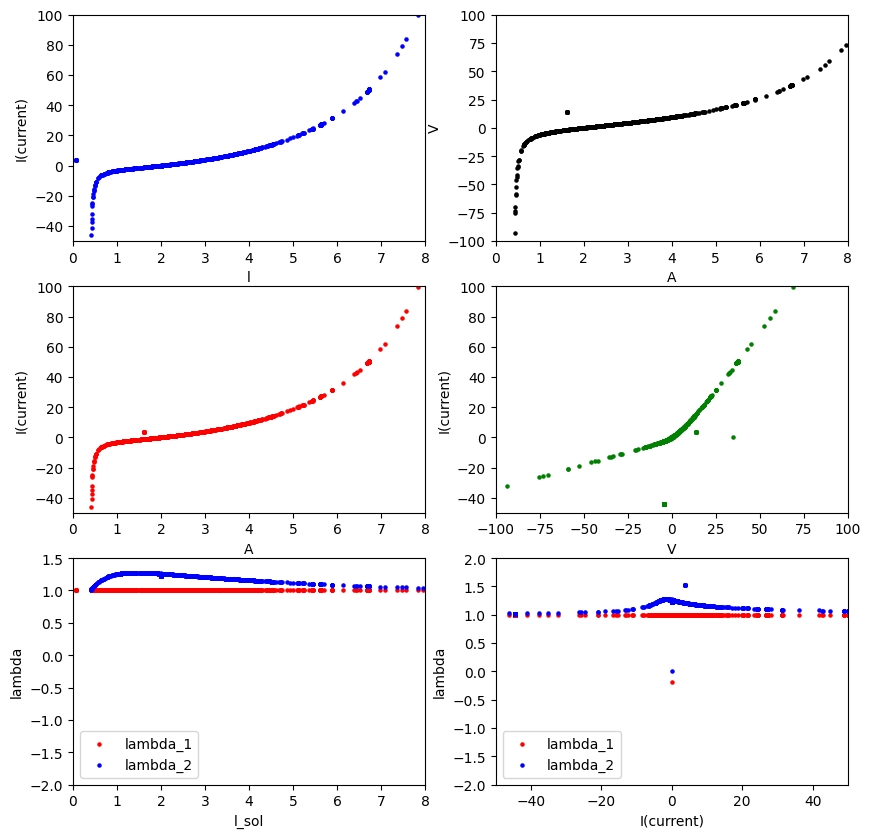

In [6]:
r = 2

# Calculate lmd1 and lmd2
lmd1 = 3*(l_sol - A_sol + I_sol) * \
       (np.log(np.maximum(l_sol/r, 1e-15))) / \
       ((l_sol - r) * (V_sol + np.log(np.maximum(l_sol/r, +1e-15))))

lmd2 = 3*(l_sol - A_sol - I_sol) * \
       (np.log(np.maximum(l_sol/r, +1e-15))) / \
       ((l_sol - r) * (-V_sol + np.log(np.maximum(l_sol/r, +1e-15))))

# Generate t vector
t = np.arange(len(lmd1))

# plot the solutions
fig, axs = plt.subplots(3, 2, figsize=(10, 10))
axs[0, 0].scatter(l_sol, I_sol, s=5, c='blue')
axs[0, 0].set_xlabel('l')
axs[0, 0].set_ylabel('I(current)')
axs[0,0].set_xlim(0, 8)  # Adjust the x-axis limits
axs[0,0].set_ylim(-50, 100)  # Adjust the y-axis limits

axs[0, 1].scatter(A_sol, V_sol, s=5, c='black')
axs[0, 1].set_xlabel('A')
axs[0, 1].set_ylabel('V')
axs[0,1].set_xlim(0, 8)  # Adjust the x-axis limits
axs[0,1].set_ylim(-100, 100)  # Adjust the y-axis limits

axs[1, 0].scatter(A_sol, I_sol, s=5, c='red')
axs[1, 0].set_xlabel('A')
axs[1, 0].set_ylabel('I(current)')
axs[1,0].set_xlim(0, 8)  # Adjust the x-axis limits
axs[1,0].set_ylim(-50, 100)  # Adjust the y-axis limits

axs[1, 1].scatter(V_sol, I_sol, s=5, c='green')
axs[1, 1].set_xlabel('V')
axs[1, 1].set_ylabel('I(current)')
axs[1, 1].set_xlim(-100, 100)  # Adjust the x-axis limits
axs[1, 1].set_ylim(-50, 100)  # Adjust the y-axis limits
# Plot lmd1 and lmd2 using scatter plots

axs[2, 0].scatter(l_sol, lmd1, label='lambda_1',s=5, color='red')
axs[2, 0].scatter(l_sol, lmd2, label='lambda_2', s=5, color='blue')
axs[2, 0].set_xlabel('l_sol')
axs[2, 0].set_ylabel('lambda')
axs[2, 0].legend()
axs[2, 0].set_xlim(0, 8)  # Adjust the x-axis limits
axs[2, 0].set_ylim(-2, 1.5)  # Adjust the y-axis limits

axs[2, 1].scatter(I_sol, lmd1, label='lambda_1', s=5, color='red')
axs[2, 1].scatter(I_sol, lmd2, label='lambda_2', s=5, color='blue')
axs[2, 1].set_xlabel('I(current)')
axs[2, 1].set_ylabel('lambda')
axs[2, 1].legend()
axs[2, 1].set_xlim(-50, 50)  # Adjust the x-axis limits
axs[2, 1].set_ylim(-2, 2)  # Adjust the y-axis limits
plt.show()

# x0 = [0.5, 0.5, 5, 5]
# sol = root(equations, x0, method='hybr')
# sol = root(equations, x0, method='broyden1')
# sol = root(equations, x0, method='anderson')

# print(sol.x)